# Import libraries and set configs

In [1]:
import sys
sys.path.append("..")

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password

from datetime import datetime


class CFG:
    load = False
    historical = False
    create_dataset = False
    update_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = "both"
    patterns_to_filter = ["STOCH_RSI_Volume24"]
    select_features = False
    optimize = False
    optimize_alpha = 0.05
    n_repeats = 1
    n_folds = 8
    last_date = datetime.strptime("2024-07-06:12:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

tqdm.pandas()

warnings.simplefilter(action="ignore", category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "buy"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "sell"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob("../optimizer/ticker_dataframes/*_1h.pkl")
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df["time"].diff()[1:].nunique()
    if nunique > 1:
        count = df[df["time"].diff().astype("timedelta64[h]") != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + "4h.pkl")
            
counter

  0%|          | 0/3534 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

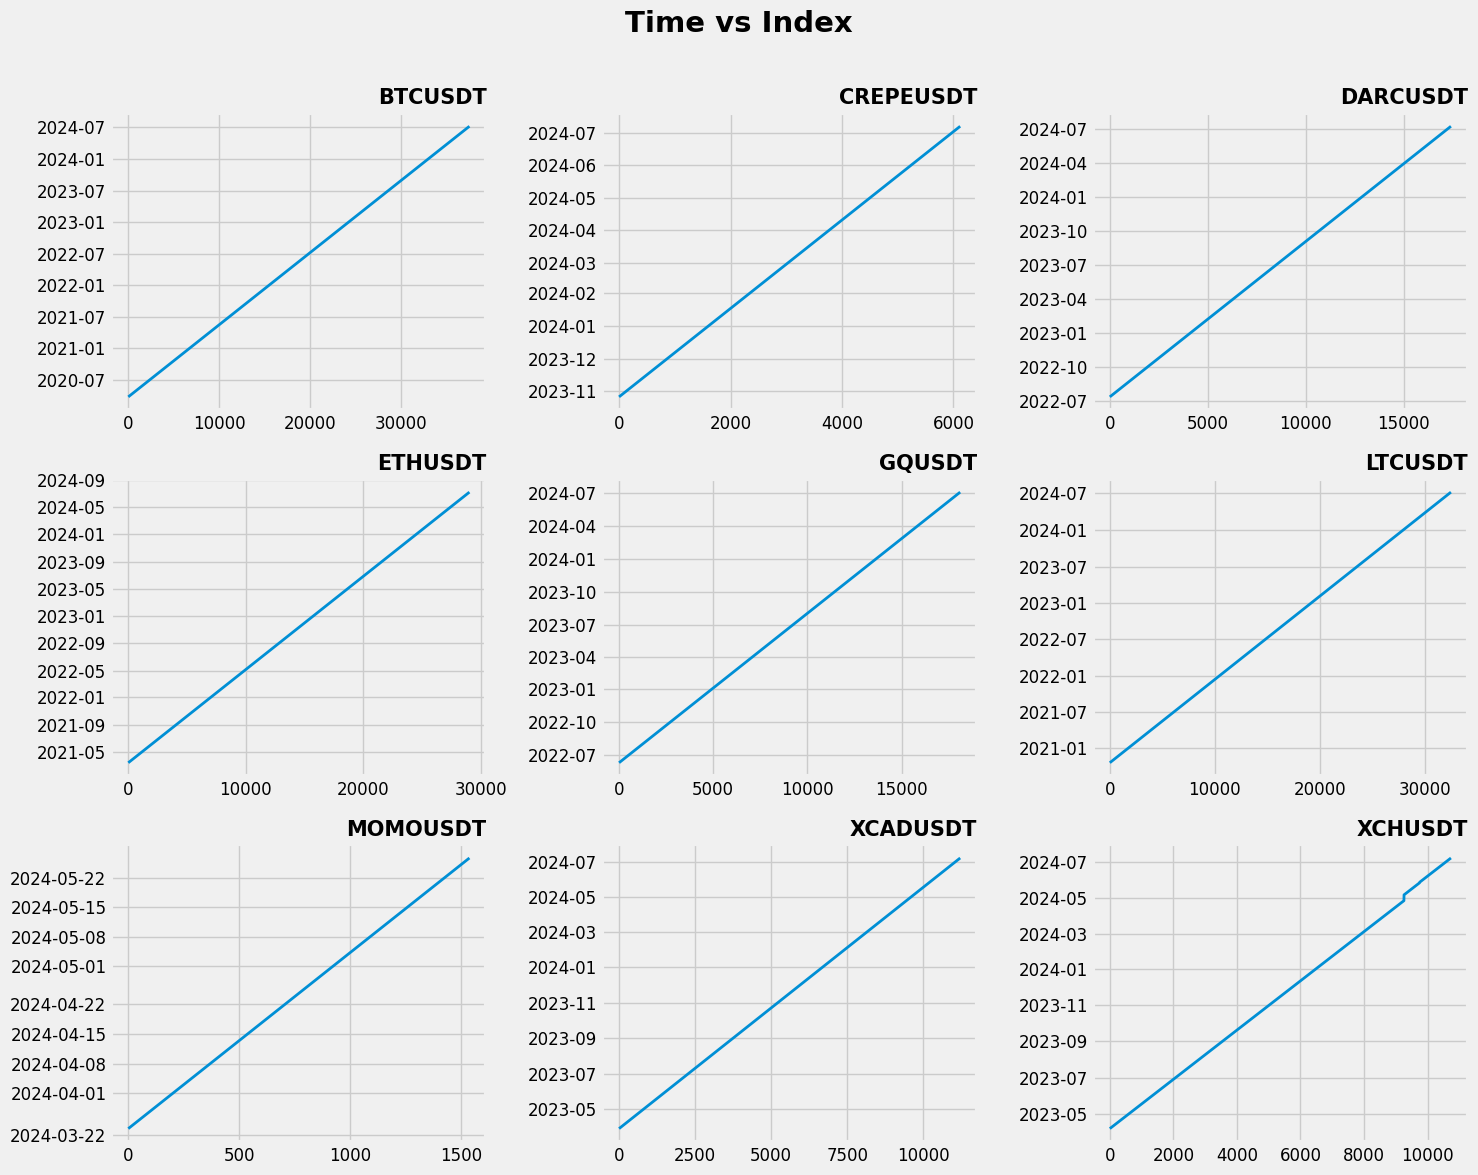

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob("../optimizer/ticker_dataframes/*_1h.pkl")
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if "/BTCUSDT_1h" in t or "/ETHUSDT_1h" in t or "/LTCUSDT_1h" in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df["time"])

        ax.set_ylabel("")
        plt.yticks(fontsize=12) 
        ax.set_xlabel("")
        plt.xticks(fontsize=12)
        # ax.spines["right"].set_visible(False)
        ax.set_title(f"{random_tickers[idx].split('/')[-1][:-7]}", loc="right", weight="bold", fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f"Time vs Index\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob("../optimizer/ticker_dataframes/*.pkl")
y = [i[31:].split("_")[0] for i in x]
z = ("").join(x)

for i in y:
    if f"{i}_1h" not in z:
        print(i, "1h")
    if f"{i}_4h" not in z:
        print(i, "4h")

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ["time", "linear_reg", "linear_reg_angle", "macd", "macdhist", "macdsignal"]
price_cols = ["open","high", "low", "close"]
real_price_cols = ["real_high", "real_low", "real_close"]
funding_cols = ["funding_rate"]
rsi_stoch_cols = ["rsi", "stoch_diff", "stoch_slowd", "stoch_slowk"]
btcd_cols = ["time", "btcd_open", "btcd_high", "btcd_low", "btcd_close", "btcd_volume"]
btcdom_cols = ["time", "btcdom_open", "btcdom_high", "btcdom_low", "btcdom_close", "btcdom_volume"]

def get_file(ticker):
    """ Find files buy ticker names """
    try:
        tmp_df_1h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
        tmp_df_4h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h


def add_indicators(df: pd.DataFrame, df_higher: pd.DataFrame, ttype: str, configs: dict) -> pd.DataFrame:
    """Create indicators and add them to the dataset"""
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, "", "", 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, "", "", 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, "", "", 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, "", "", 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, "", "", 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, "", "", 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, "", "", 0)
    # merge higher timeframe indicators with working timeframe
    df_higher["time"] = df_higher["time"] + pd.to_timedelta(3, unit="h")
    df[higher_features] = pd.merge(df[["time"]], df_higher[higher_features], how="left", on="time")
    df = df.drop(columns=["close_smooth"])
    df = df.drop(columns=[c for c in df.columns if c.endswith("_dir")])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[["time"]], btcd[btcd_cols], how="left", on="time")
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[["time"]], btcdom[btcdom_cols], how="left", on="time")
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[["high", "low", "close"]]
    cols_to_scale = ["open", "high", "low", "close", "macd", "macdhist", "macdsignal", "atr"]
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ["close", "btcd_close", "btcdom_close"]:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f"{col}_{agg_func.__name__}_{period}"] = df[col].rolling(period, min_periods=1).agg({"func": agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    """ Create train dataset from signal statistics and ticker candle data"""
    train_df = list()
    tickers = df["ticker"].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df["ticker"] == ticker]
        times = signal_df["time"]
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev["ticker"] == ticker, "time"].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f"TypeError, ticker - {ticker}")
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc("pattern")]
            row = tmp_df_1h.loc[tmp_df_1h["time"] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h["time"] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f"_prev_{i}" for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row["ticker"] = ticker
                row["pattern"] = pattern
                
            if pass_cycle:
                continue

            row["target"] = 0
            row["max_price_deviation"] = 0
            row["ttype"] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith("MACD"):
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t + timedelta(hours=3), "real_close"]
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t, "real_close"]

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue
            
            close_price = close_price.values[0]
            higher_price = close_price * CFG.cls_target_ratio_tp
            lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
            
            target_buys, target_sells = [], []
            for i in range(1, target_offset + 1):
                
                if pattern.startswith("MACD"):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_high"]
                target_sell = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_low"]
                
                target_buys.append(target_buy)
                target_sells.append(target_sell)
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set TPs and SLs
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row["pattern"].values[0]
                ttype = row["ttype"].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith("STOCH") and ttype == "buy" and target_buy_sl == 1
                sl2 = pattern.startswith("STOCH") and ttype == "sell" and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith("STOCH") and ttype == "buy" and target_sell_tp == 1
                tp2 = pattern.startswith("STOCH") and ttype == "sell" and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row["target"] = 1
                    # break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_close"].values[0]
                    l1 = pattern.startswith("STOCH") and ttype == "buy" and last_price < close_price
                    l2 = pattern.startswith("STOCH") and ttype == "sell" and last_price > close_price

                    if l1 or l2:
                        row["target"] = 1

                # set the maximum price deviation to the correct side for the current trade period 
                if ttype == "sell":
                    curr_price = (target_buy - close_price) / close_price
                else:
                    curr_price = (close_price - target_sell) / close_price
                
                row["max_price_deviation"] = max(row["max_price_deviation"].values[0], curr_price) 
            
            if pass_cycle:
                continue
            
            if row["max_price_deviation"].values[0] <= 0.02 and row["target"].values[0] == 1:
                max_price_deviation = row["max_price_deviation"].values[0]
                pass
            
            # add data to the dataset
            train_df.append(row)
    
    train_df = pd.concat(train_df).reset_index(drop=True)
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist("BTC.D","CRYPTOCAP", interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns="symbol")
    btcd.columns = btcd_cols
    btcd["time"] = btcd["time"] + pd.to_timedelta(23, unit="h")

    btcdom = tv.get_hist("BTCDOMUSDT.P","BINANCE", interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns="symbol")
    btcdom.columns = btcdom_cols
    btcdom["time"] = btcdom["time"] + pd.to_timedelta(3, unit="h")
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 4, 15, 16, 17, 18, 22, 23]
    df = df[df["time"].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_buy_{last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, "buy", configs, target_offset, first, last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f"signal_stat/train_buy_{last}.pkl")

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [9, 14, 17, 23]
    df = df[df["time"].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_sell_{last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, "sell", configs, target_offset, first, last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f"signal_stat/train_sell_{last}.pkl")

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, "buy", configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values("time").reset_index(drop=True)

    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, "sell", configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values("time").reset_index(drop=True)

    del df

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f"signal_stat/train_buy_{last}.pkl")
train_sell = pd.read_pickle(f"signal_stat/train_sell_{last}.pkl")

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values("time")

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df["time"] < train_df["time"].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if "prev" not in c and "sar" in c]

# Data tests

### Test train dataframe columns

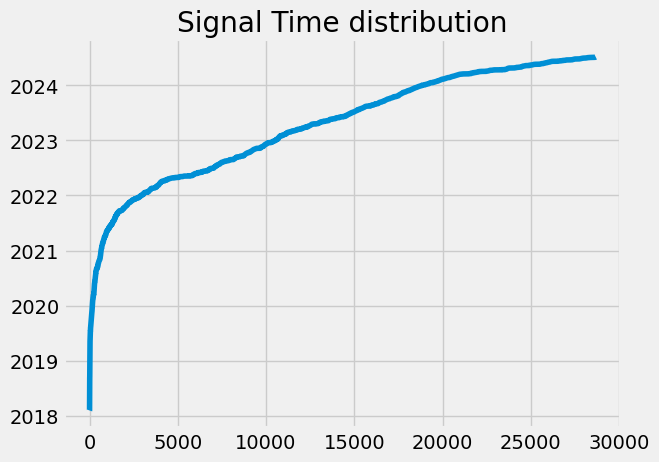

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r"_prev_\d+", "", c) for c in train_buy.columns)

    agg_funcs = ["amin", "amax", "mean", "median", "std"]
    agg_cols = [c for c in cols if len(c.split("_")) > 2 and c.split("_")[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ["atr", "cci", "sar", "volume", "pattern", "target", "max_price_deviation", "ticker", "ttype"])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ("rsi" in c or "stoch" in c) and "diff" not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if "volume" in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith("funding")]
    for f_c in funding_cols_:
        num = "".join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith("btcd_") and "volume" not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = "".join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = "".join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df["time"].plot(title="Signal Time distribution")


### Test buy target corectness

In [11]:
prev_ticker = None

train_buy_ = train_buy[train_buy["ticker"] == "MILOUSDT"]

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]
        if ticker != "MILOUSDT":
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        
        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

  0%|          | 0/23250 [00:00<?, ?it/s]

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]

        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/5431 [00:00<?, ?it/s]

### Test pattern / target distribution

In [13]:
def q10(x):
    return x.quantile(0.1)

def q40(x):
    return x.quantile(0.4)

def q90(x):
    return x.quantile(0.9)

def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row["total"], row["count"]
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy[(train_buy["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q40, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q40", 
               "max_price_dev_q90", "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Buy")
display(pvt)
display(train_buy["ttype"].value_counts())
display(train_buy[["target", "pattern"]].value_counts())
display(train_buy[["target", "pattern"]].value_counts(normalize=True))

pvt = train_sell[(train_sell["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q40, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q40", 
               "max_price_dev_q90", "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Sell")
display(pvt)
display(train_sell["ttype"].value_counts())
display(train_sell[["target", "pattern"]].value_counts())
display(train_sell[["target", "pattern"]].value_counts(normalize=True))

Buy


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q40,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.074597,0.035229,0.061224,0.253041,1181,2019,0.584943,"(0.5636, 0.6063)"
3,1,1,0.071096,0.035702,0.060007,0.226496,1225,2221,0.551553,"(0.531, 0.5721)"
5,2,1,0.069376,0.034883,0.057845,0.230504,1280,2266,0.564872,"(0.5446, 0.5852)"
7,3,1,0.075273,0.035655,0.063064,0.220879,1382,2539,0.544309,"(0.525, 0.5636)"
9,4,1,0.079132,0.035956,0.064629,0.232410,1325,2560,0.517578,"(0.4983, 0.5368)"
11,15,1,0.088718,0.035997,0.070904,0.230709,1149,2151,0.534170,"(0.5132, 0.5551)"
13,16,1,0.088569,0.036542,0.070615,0.240453,1027,1928,0.532676,"(0.5105, 0.5548)"
15,17,1,0.084832,0.036059,0.068579,0.233954,1058,1907,0.554798,"(0.5326, 0.577)"
17,18,1,0.086360,0.035892,0.069947,0.223995,1027,1865,0.550670,"(0.5282, 0.5731)"
19,22,1,0.089139,0.037848,0.071864,0.259281,1062,1995,0.532331,"(0.5105, 0.5541)"


buy    23250
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    12753
0       STOCH_RSI_Volume24    10497
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.548516
0       STOCH_RSI_Volume24    0.451484
dtype: float64

Sell


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q40,max_price_dev_q90,count,total,pct,trust_interval
1,9,1,0.082381,0.035862,0.067904,0.275560,827,1556,0.531491,"(0.5068, 0.5562)"
3,14,1,0.079683,0.036714,0.064938,0.259656,854,1610,0.530435,"(0.5062, 0.5547)"
5,17,1,0.078112,0.035304,0.064751,0.306447,595,1108,0.537004,"(0.5078, 0.5662)"
7,23,1,0.080925,0.034580,0.065366,0.304015,623,1142,0.545534,"(0.5168, 0.5743)"


sell    5431
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    2907
0       STOCH_RSI_Volume24    2524
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.535261
0       STOCH_RSI_Volume24    0.464739
dtype: float64

# Data visualization

### Plot ratio of class 1 for every week day

Monday = 0, Sunday = 6

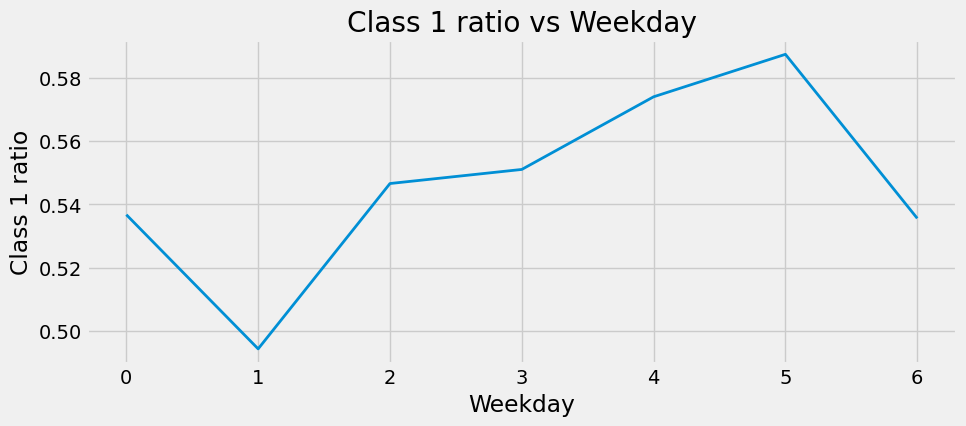

In [14]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["weekday"] = group_df["time"].dt.weekday
ax = group_df.groupby("weekday")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Weekday")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Weekday");

### Plot ratio of class 1 for every month

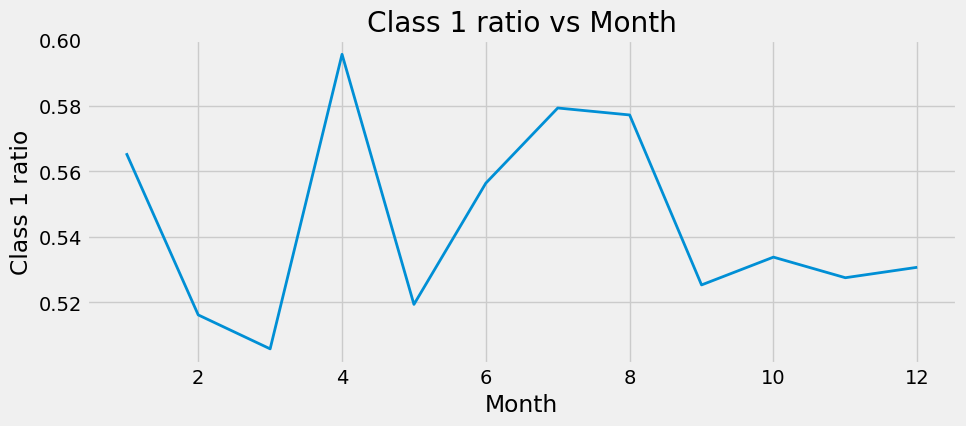

In [15]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["month"] = group_df["time"].dt.month
ax = group_df.groupby("month")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Month")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Month");

### Plot ratio of class 1 for every day of last months

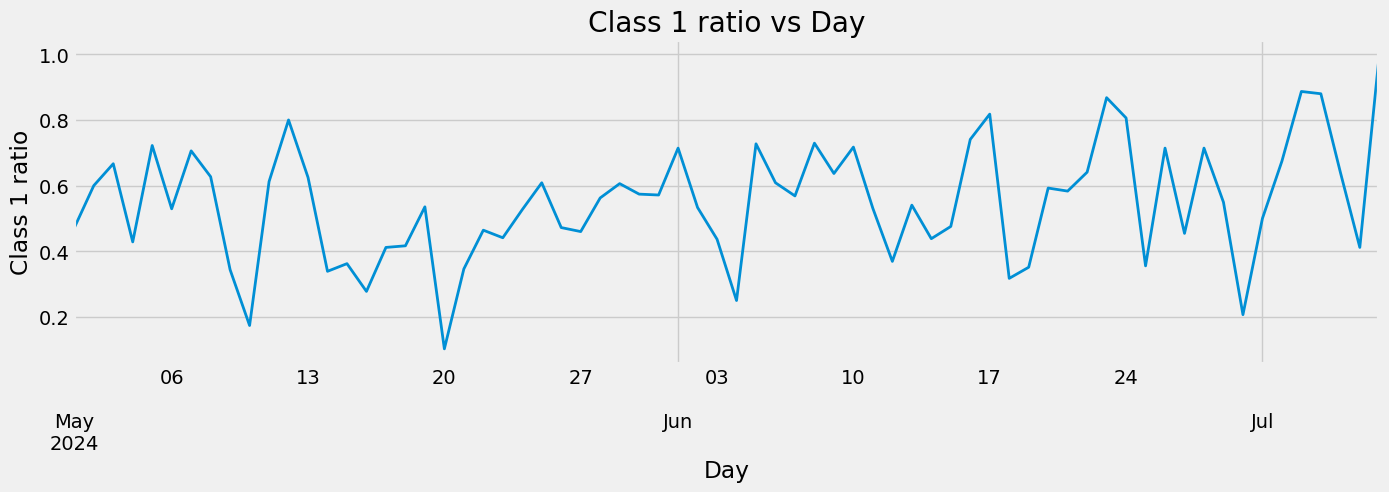

In [16]:
plt.figure(figsize=(15, 4))

group_df = train_df[(train_df["time"].dt.year >= 2024) & (train_df["time"].dt.month >= 5)]
group_df["day"] = group_df["time"].dt.to_period("D")
ax = group_df.groupby("day")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Day")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Day");

### Visualize buy trades

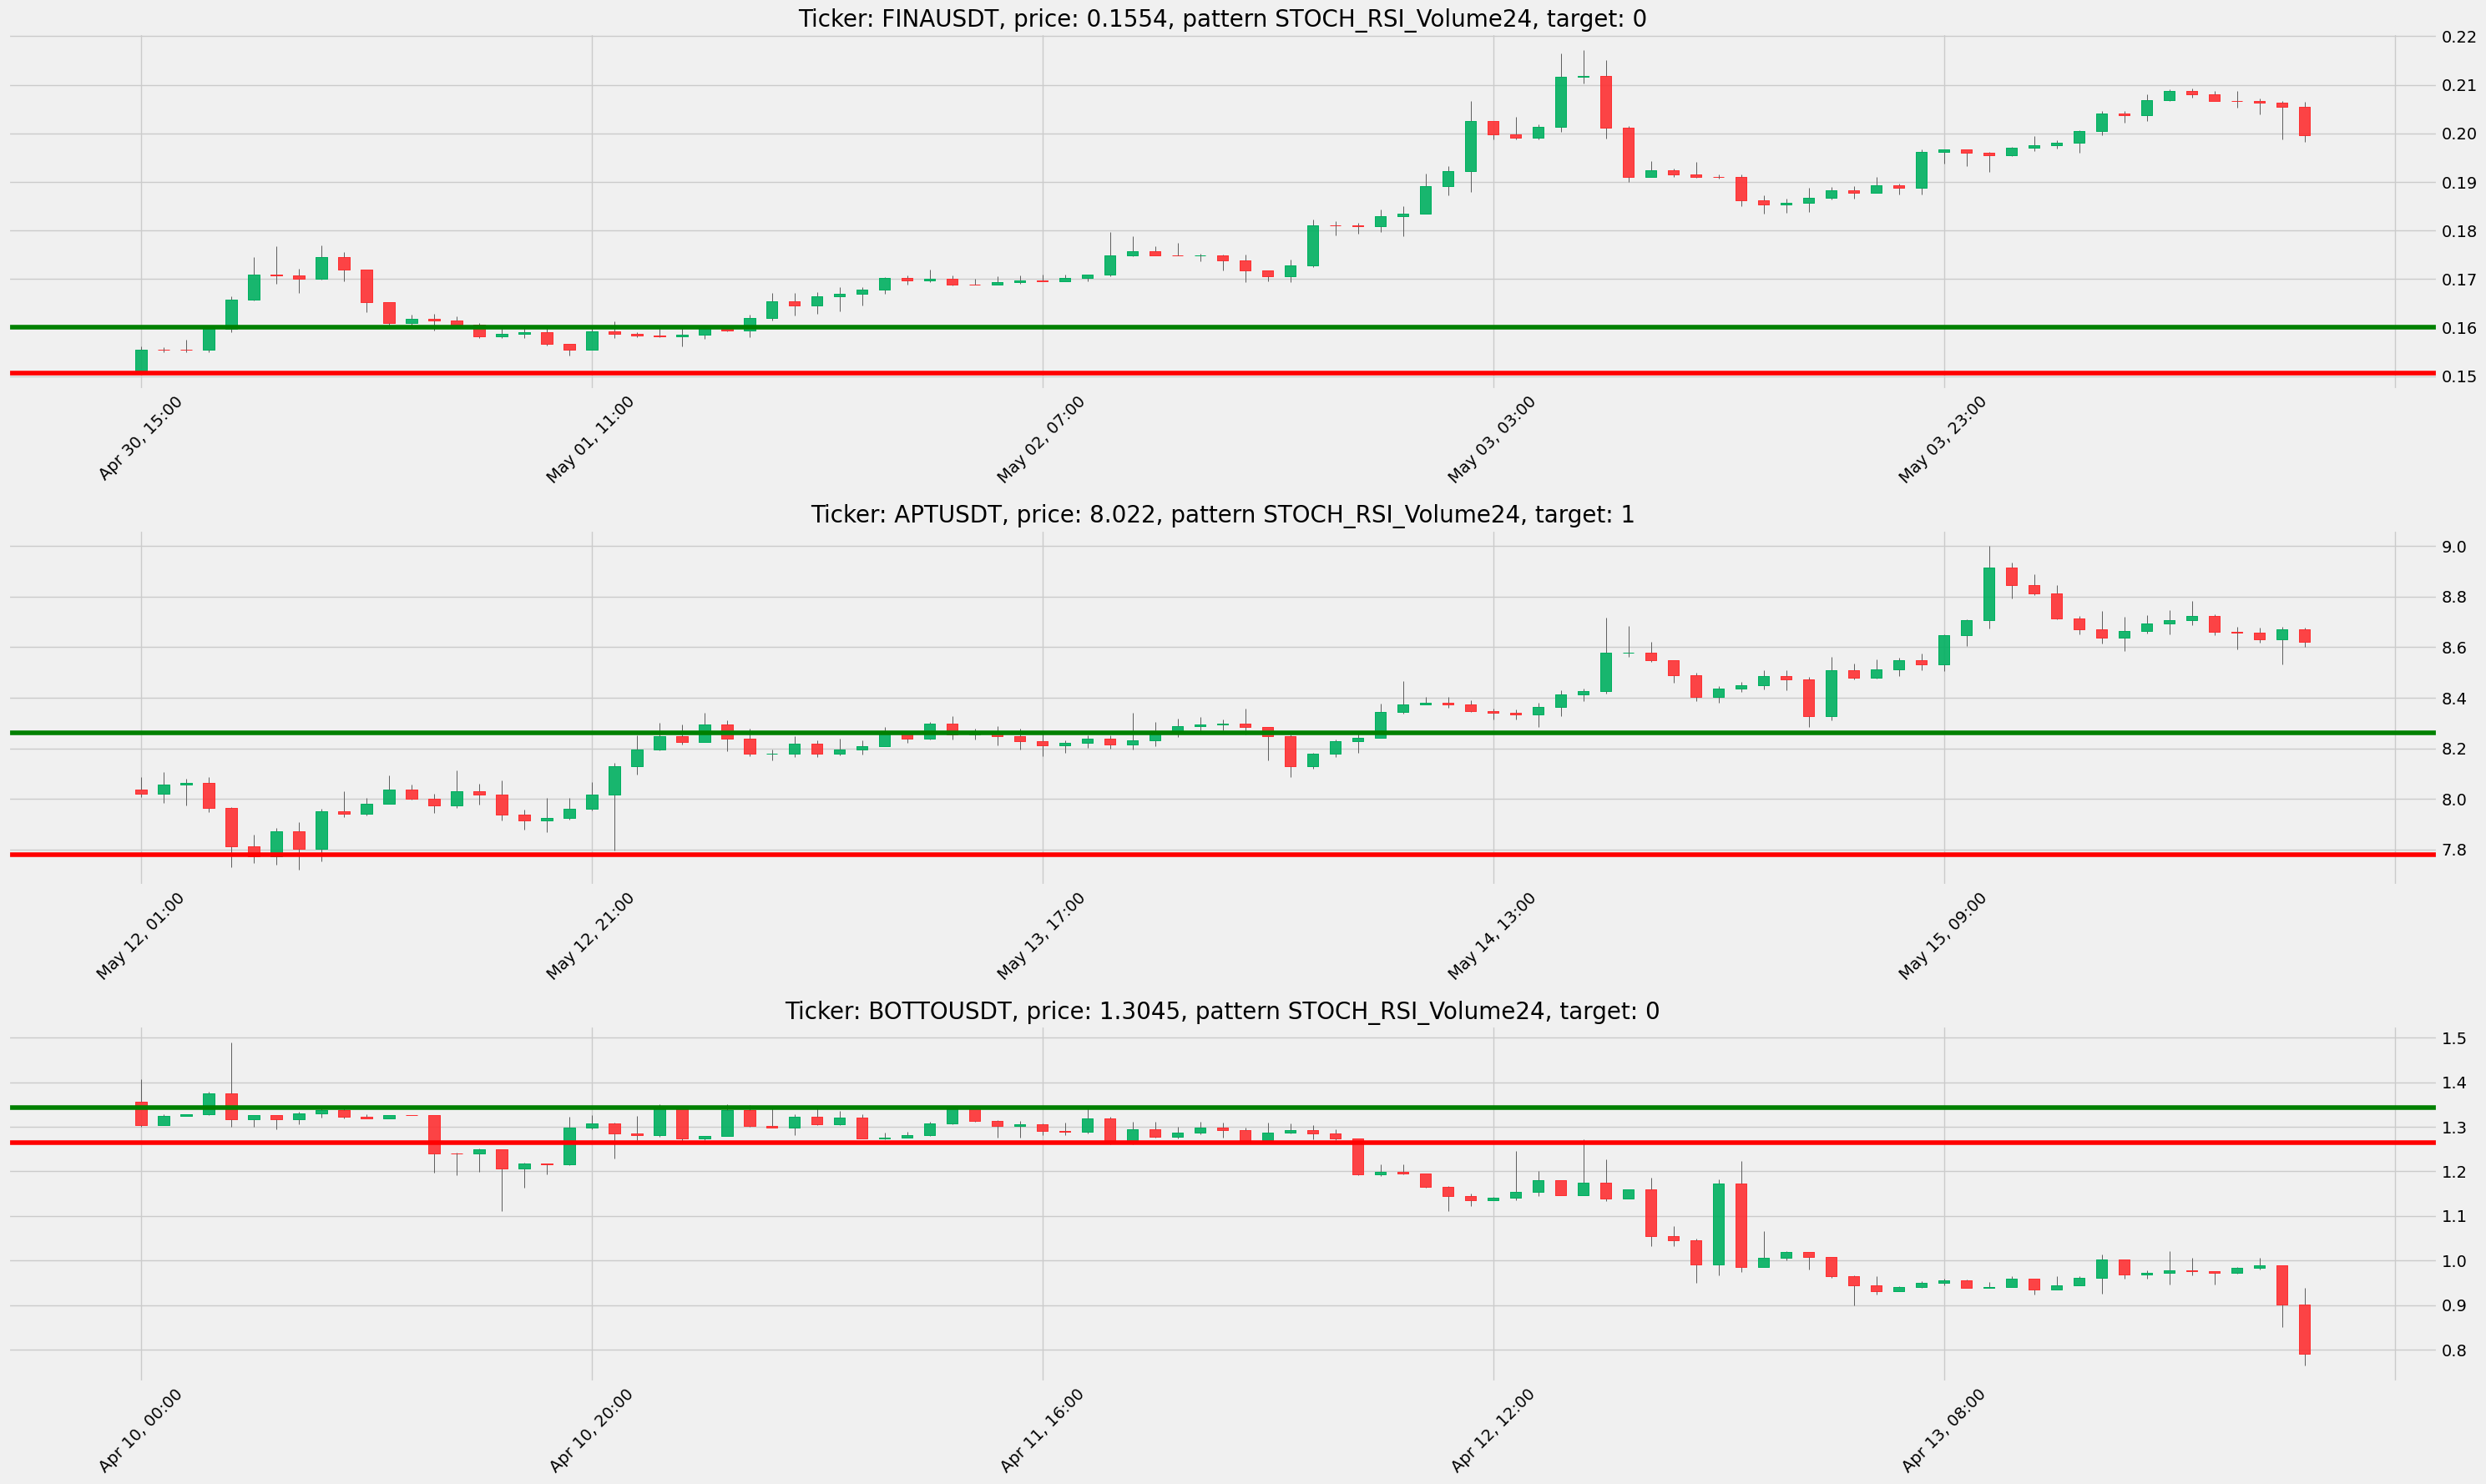

In [17]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

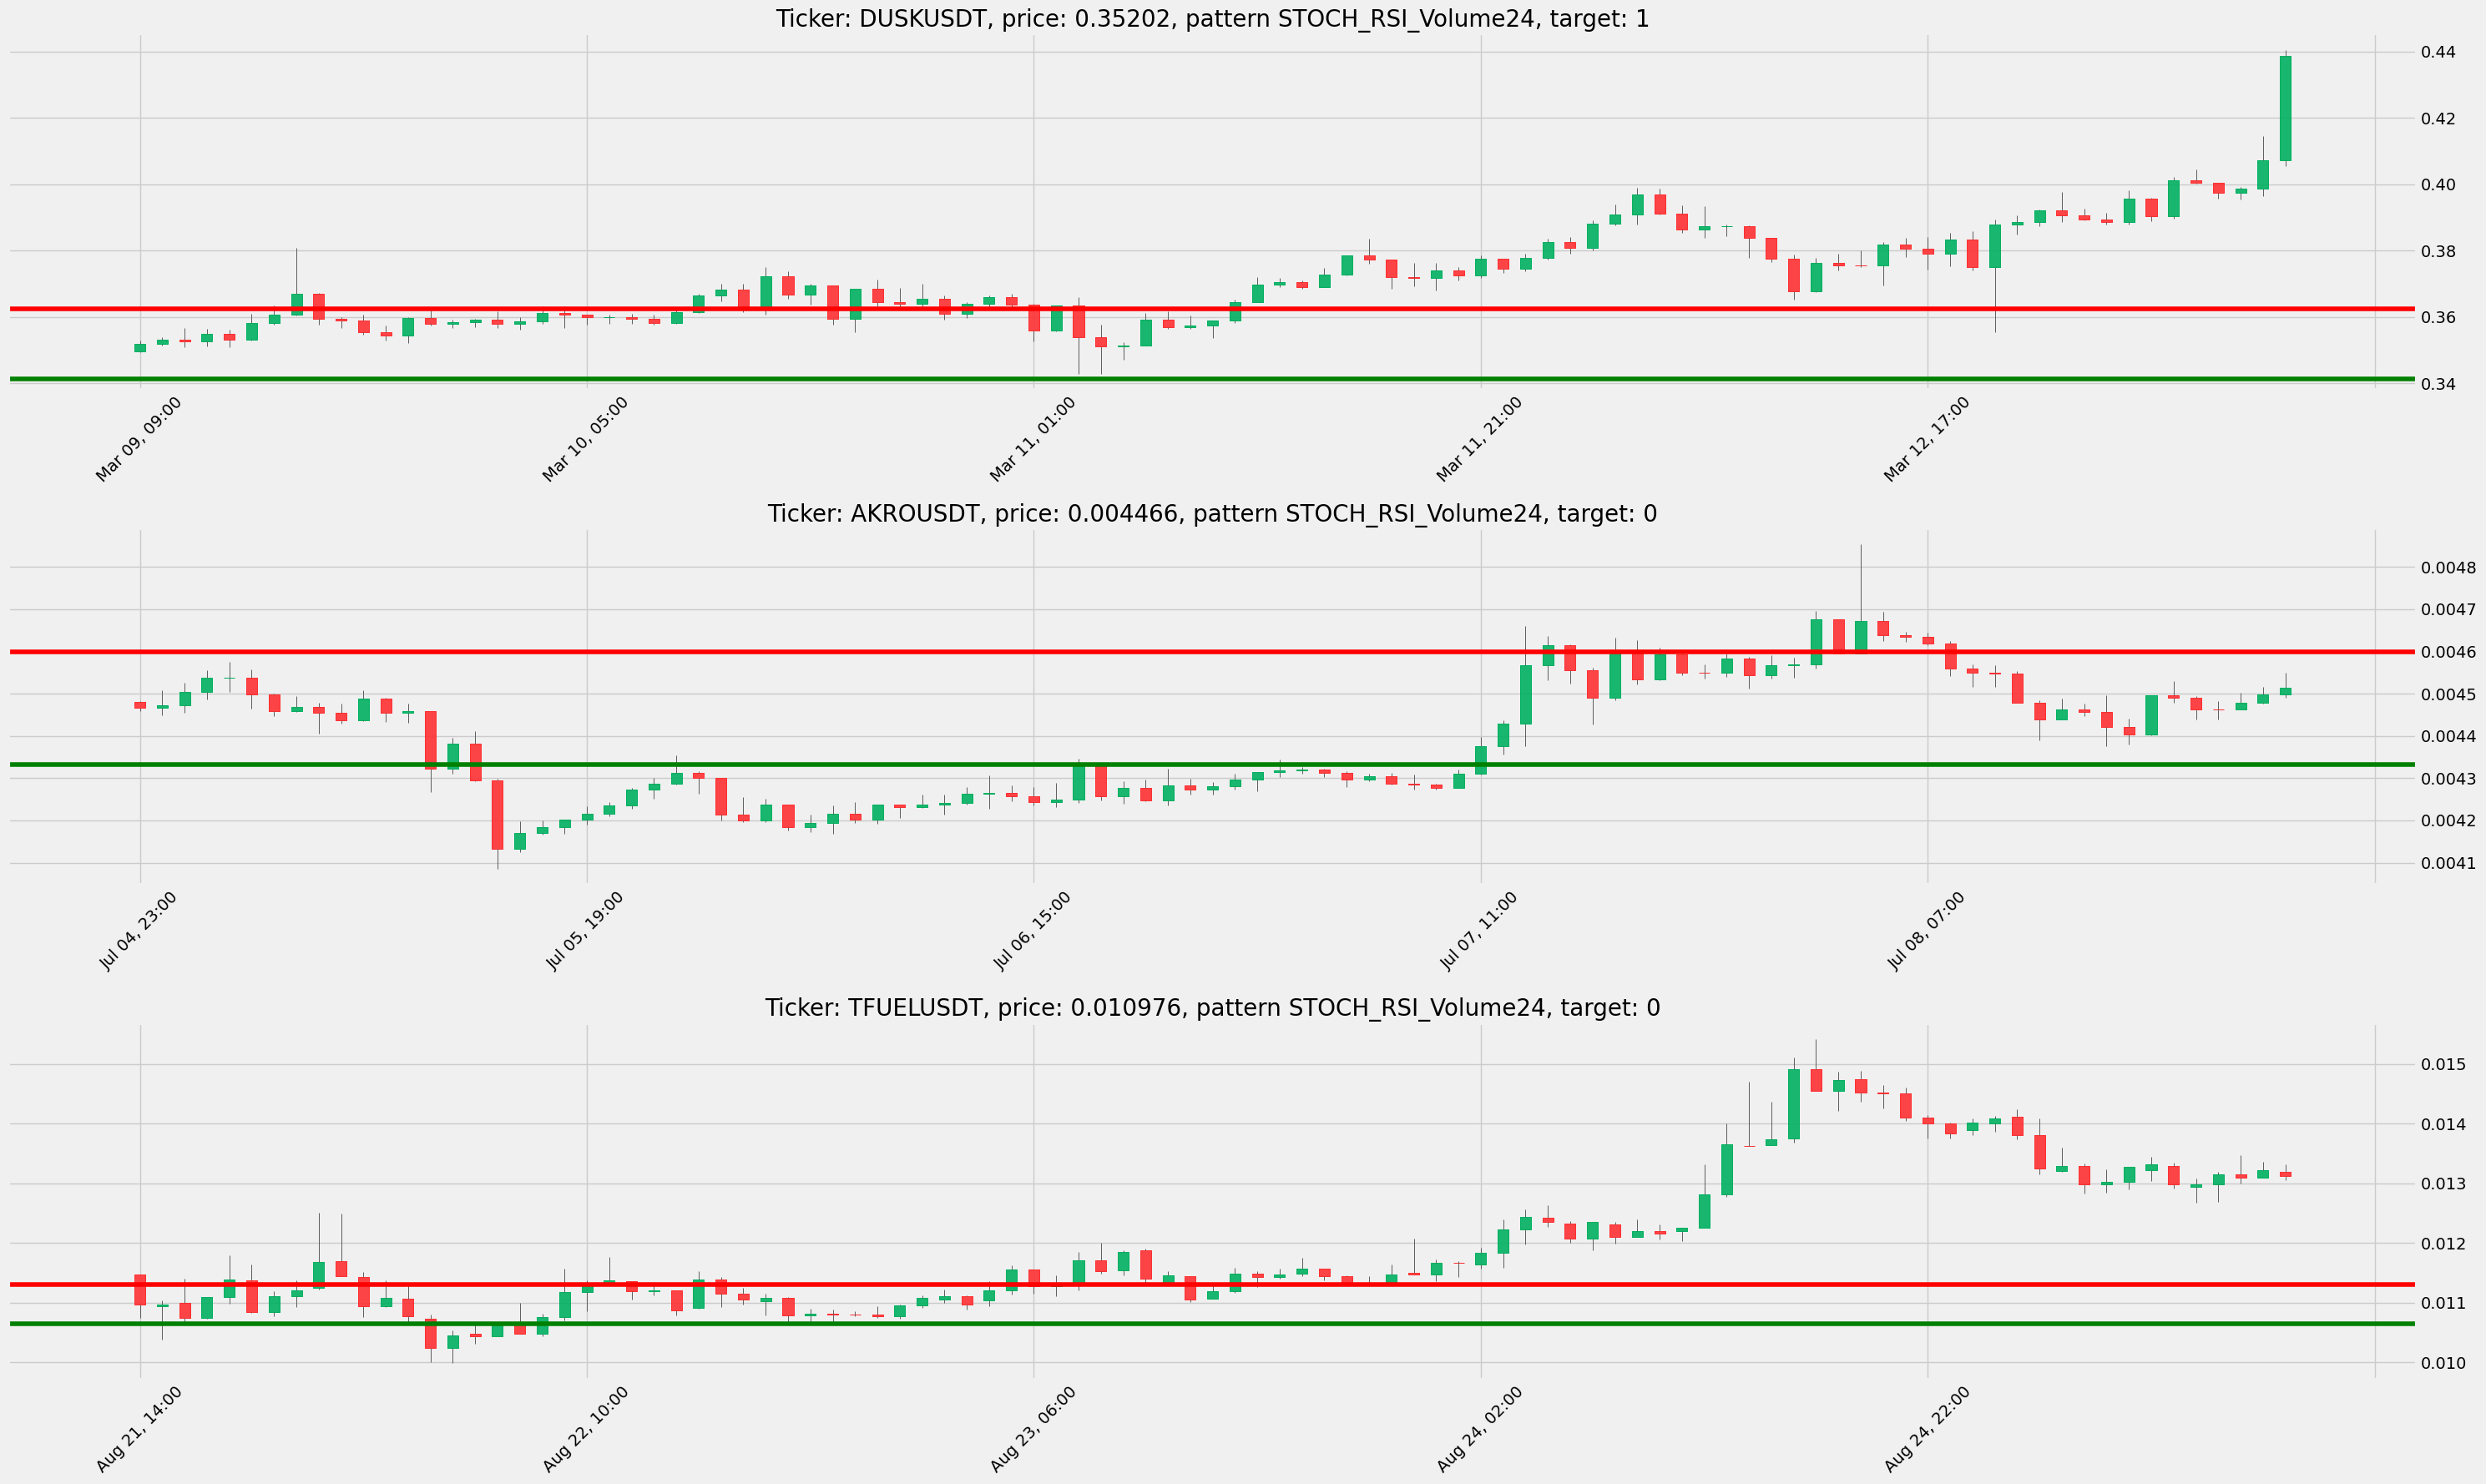

In [18]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

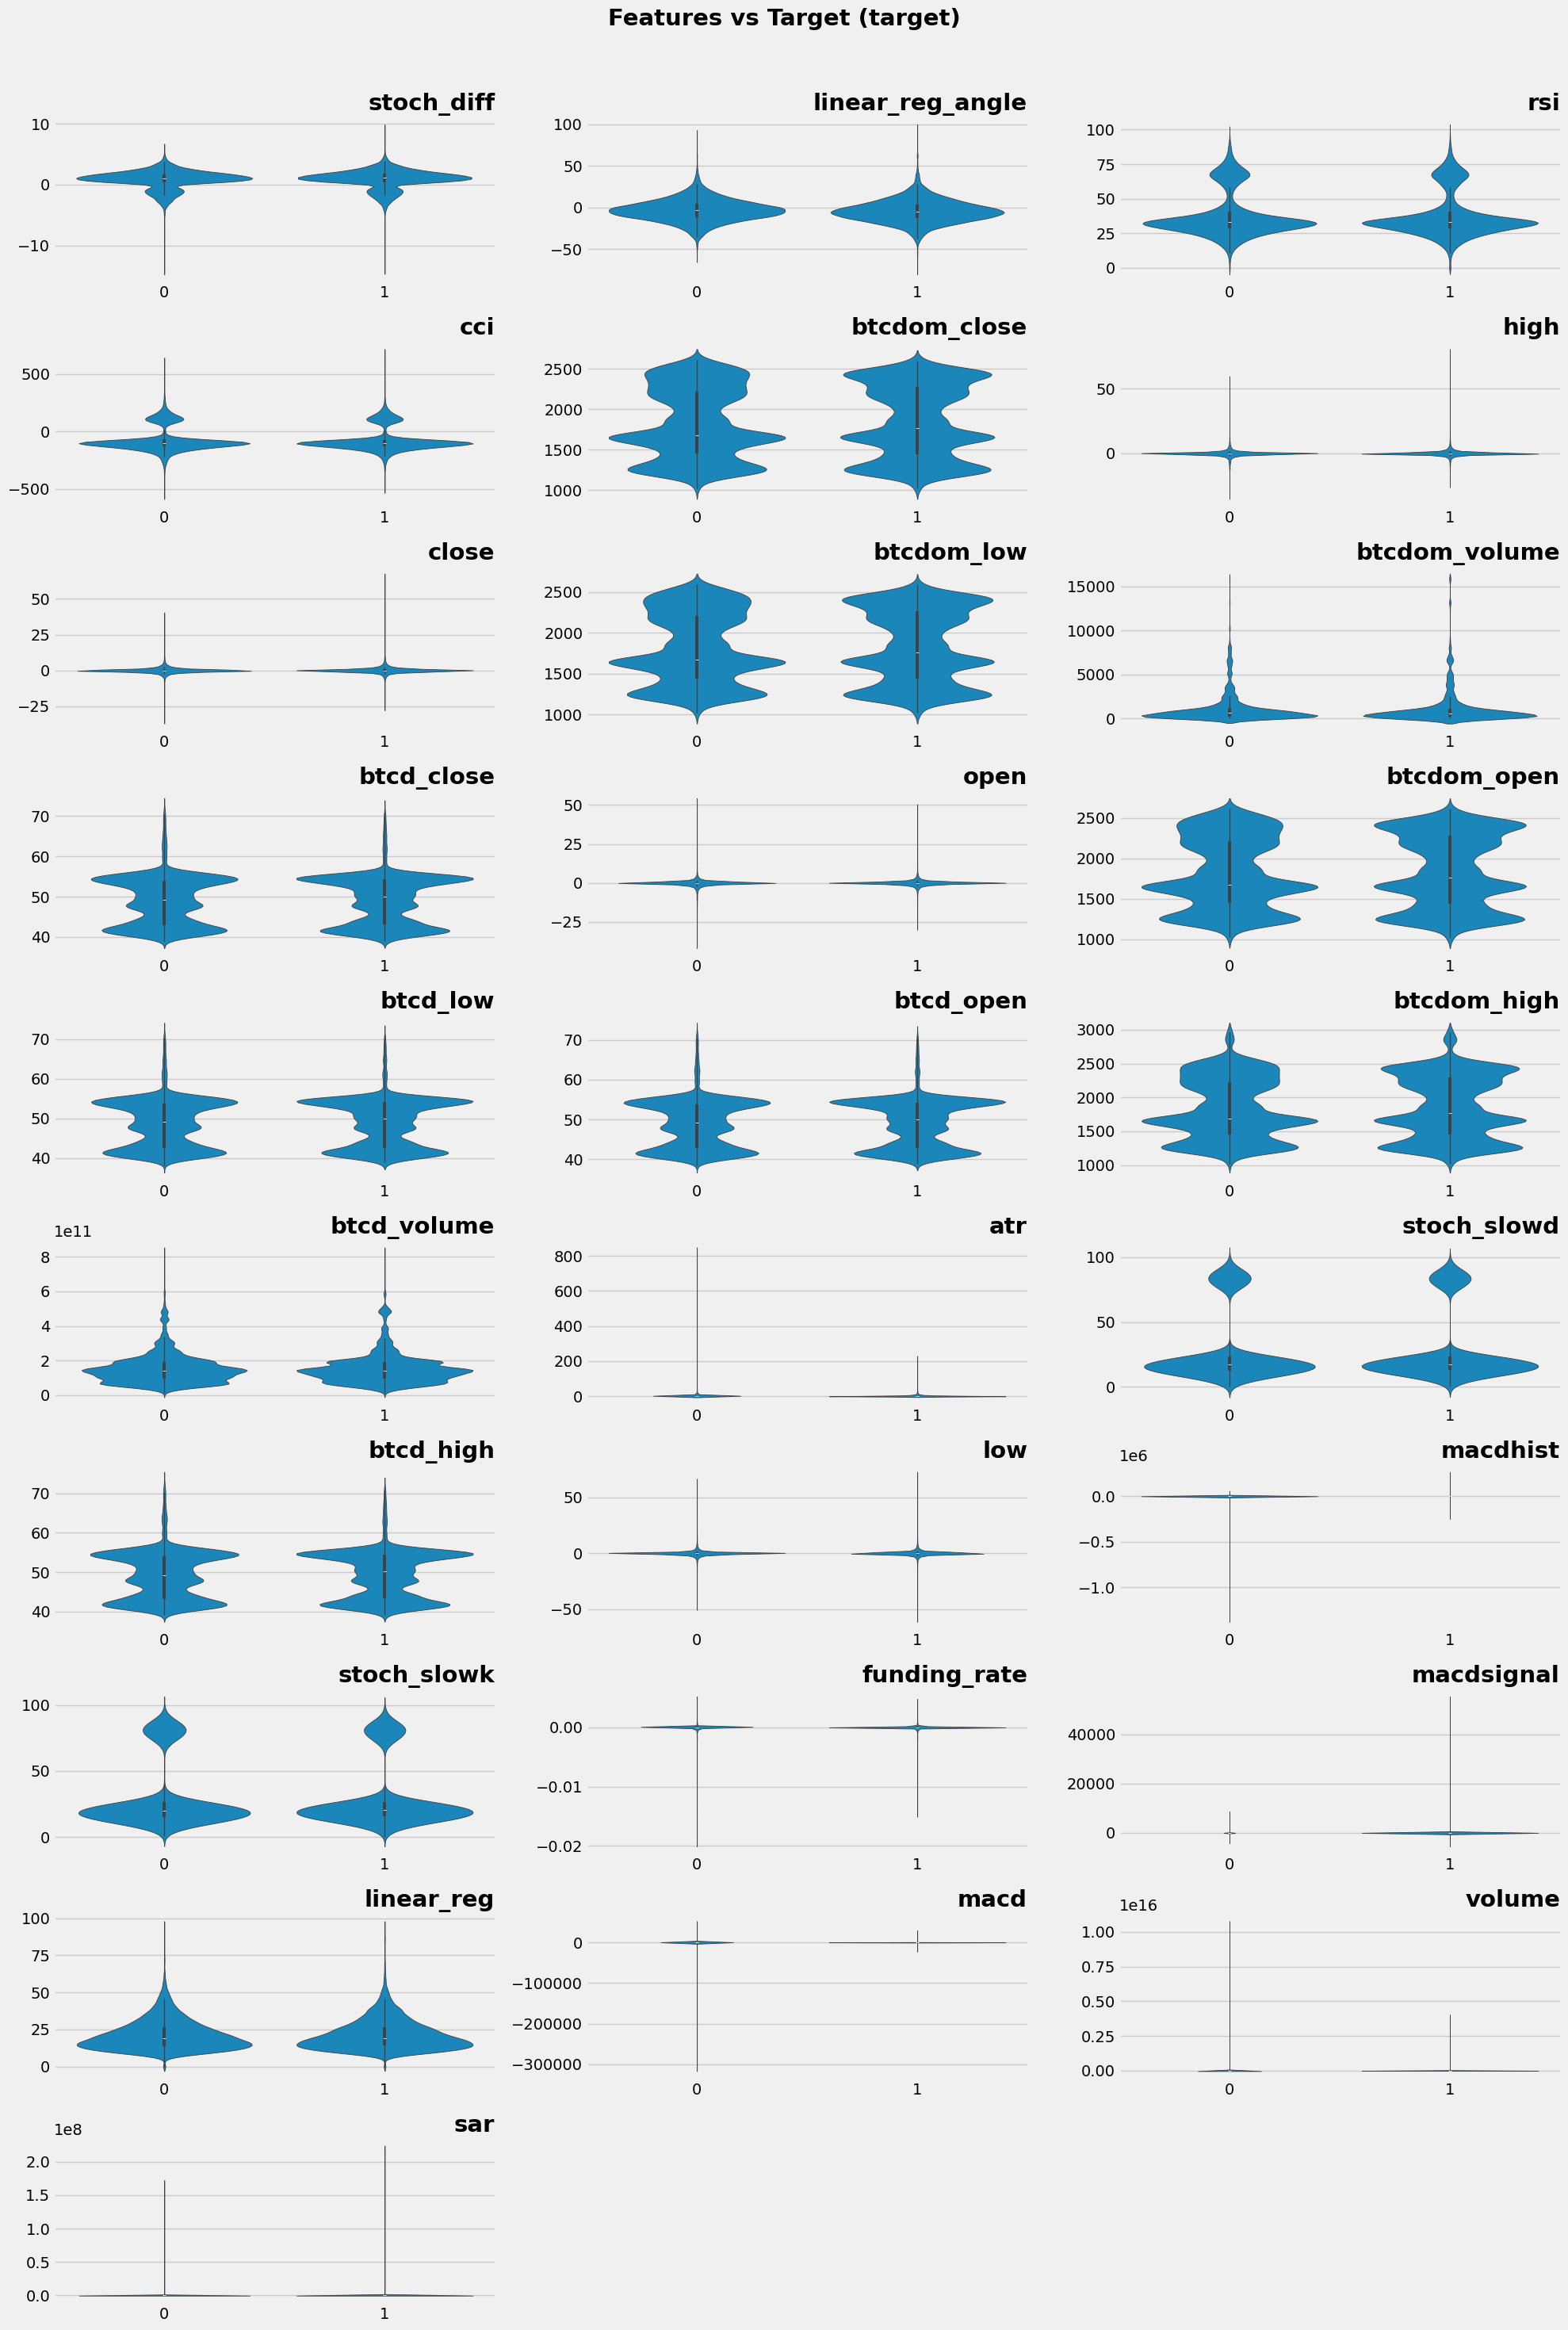

In [19]:
fi = pd.read_csv(f"model/feature_importance.csv")["Feature"].to_list()
cols = [c for c in fi if "prev" not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(""); ax.spines["top"].set_visible(False), 
        ax.set_xlabel(""); ax.spines["right"].set_visible(False)
        ax.set_title(f"{col}", loc="right", weight="bold", fontsize=21)

    
    fig.suptitle(f"Features vs Target ({target})\n\n\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target="target")

### Show the last signals

In [20]:
x = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
x["ttype"] = "buy"
y = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
y["ttype"] = "sell"
x = pd.concat([x, y]).sort_values("time").reset_index(drop=True)
x.loc[x["pattern"] == "STOCH_RSI_Volume24", ["time", "ticker", "ttype", "pattern"]].tail(35)

,time,ticker,ttype,pattern
100705,2024-07-07 04:00:00,WINUSDT,sell,STOCH_RSI_Volume24
100706,2024-07-07 04:00:00,SYSUSDT,sell,STOCH_RSI_Volume24
100707,2024-07-07 04:00:00,PUNDIXUSDT,sell,STOCH_RSI_Volume24
100708,2024-07-07 04:00:00,VIDTUSDT,sell,STOCH_RSI_Volume24
100709,2024-07-07 04:00:00,WANUSDT,sell,STOCH_RSI_Volume24
100710,2024-07-07 04:00:00,ONTUSDT,sell,STOCH_RSI_Volume24
100711,2024-07-07 04:00:00,DEGOUSDT,sell,STOCH_RSI_Volume24
100712,2024-07-07 04:00:00,AVAUSDT,sell,STOCH_RSI_Volume24
100713,2024-07-07 04:00:00,DEGENUSDT,sell,STOCH_RSI_Volume24
100714,2024-07-07 05:00:00,AIUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [21]:
from shaphypetune import BoostBoruta
  
params = {
          "boosting_type": "dart",
          "n_estimators": 1000,
          "learning_rate": 0.02,
          "max_depth": 10,
          "subsample" : 0.7,
          "colsample_bytree": 0.85,
          "num_leaves": 24,
          "verbosity": -1,
          "importance_type": "gain",
          "max_bin": 255,
          "reg_alpha": 1e-6,
          "reg_lambda": 1e-7,
          "objective": "binary",
          "metric": "auc"
        }
features = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "max_price_deviation"]]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return "ppv_npv_acc", ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = "logloss"

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f"Fold: {fold}")
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type="shap_importances", train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric="logloss", 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({"importance": model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values("importance")
    boruta_df_ = boruta_df_.reset_index().rename({"index": "Feature"}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [22]:
palette = ["#302c36", "#037d97", "#E4591E", "#C09741",
           "#EC5B6D", "#90A6B1", "#6ca957", "#D8E3E2"]

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f"Repeat {blu}#{fold+1}")

        X, y, time = df[features], df["target"], df["time"]
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric="logloss", 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f"Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}")

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=["Value","Feature"])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_["Value"] += f_i["Value"]
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({"importance": perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f"{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}")
    print(f"{'*' * 50}\n")
    
    if permut:
        perm_df_ = perm_df_.sort_values("importance", ascending=False)
        perm_df_ = perm_df_.reset_index().rename({"index": "Feature"}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values("Value", ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          "penalty": "l2",
          "max_iter": 10000,
          "C": 1
        }

    scaler = StandardScaler()
    X, y = df[features], df["target"]
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({"importance": selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({"index": "Feature"}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [24]:
if CFG.select_features:
    boruta_df_["rank"] = boruta_df_["importance"].rank()
    perm_df_["rank"] = perm_df_["importance"].rank(ascending=False)
    rfe_df_["rank"] = rfe_df_["importance"]
    feature_importances_["rank"] = feature_importances_["Value"].rank(ascending=False)

    fi = pd.concat([perm_df_[["Feature","rank"]], feature_importances_[["Feature","rank"]], rfe_df_[["Feature","rank"]],
                    boruta_df_[["Feature","rank"]]])
    fi = fi.groupby("Feature")["rank"].sum().sort_values().reset_index()
    fi.to_csv(f"model/feature_importance.csv", index=False)
else:
    fi = pd.read_csv(f"model/feature_importance.csv")

# Train

### Load selected features

In [25]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations["level_0"] != correlations["level_1"]] 
    correlations.columns = ["feature_1", "feature_2", "corr"]

    correlations = pd.merge(left=correlations, right=fi, how="left", left_on="feature_1", right_on="Feature")
    correlations = correlations.drop(columns="Feature")
    correlations = correlations.sort_values(["corr", "rank"], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations["corr"] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row["feature_1"]
        feature_2 = row["feature_2"]

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    """ Get features, sort them by their time appearance and return for using in train and inference"""
    # exclude some features 
    fi = fi["Feature"]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == "volume_24":
            feature_dict[0].append(f)
            continue
        period = f.split("_")
        if period[-1].isdigit() and period[-2] == "prev":
            feature_dict[int(period[-1])].append("_".join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f"_prev_{item[0]}" for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ["weekday", "hour"]
    
    # remove highly correlated features from the feature dict
    feature_dict["features"] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f"{f}_prev_{item[0]}"
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

feature_num = 45
corr_thresh = 0.8489494645123489

train_df["hour"] = train_df["time"].dt.hour
train_df["weekday"] = train_df["time"].dt.weekday
fi = pd.read_csv("model/feature_importance.csv")
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['stoch_diff',
 'linear_reg_angle',
 'rsi',
 'btcdom_close',
 'high',
 'cci_prev_4',
 'btcdom_volume_prev_4',
 'stoch_diff_prev_4',
 'rsi_prev_8',
 'stoch_slowd_prev_8',
 'btcdom_volume_prev_20',
 'btcd_volume_prev_24',
 'btcdom_volume_prev_28',
 'stoch_diff_prev_28',
 'btcdom_volume_prev_40',
 'btcdom_volume_prev_56',
 'rsi_prev_68',
 'high_prev_80',
 'btcd_volume_prev_96',
 'btcdom_volume_prev_100',
 'btcdom_volume_prev_108',
 'low_prev_112',
 'btcdom_volume_prev_116',
 'btcdom_volume_prev_124',
 'btcdom_volume_prev_128',
 'btcdom_volume_prev_136',
 'btcdom_volume_prev_140',
 'btcdom_volume_prev_148',
 'btcdom_volume_prev_152',
 'btcdom_volume_prev_164',
 'cci_prev_168',
 'btcdom_volume_prev_172',
 'btcdom_volume_prev_184',
 'btcd_volume_prev_192',
 'btcdom_volume_prev_192',
 'btcdom_volume_prev_196',
 'btcdom_volume_prev_216',
 'btcdom_volume_prev_220',
 'low_prev_224',
 'btcdom_volume_prev_232',
 'btcd_volume_prev_240',
 'btcdom_volume_prev_248',
 'btcd_volume_prev_264',
 'weekday'

45

### Functions for train

In [26]:
from __future__ import annotations
from typing import Tuple
from scipy.stats import ttest_rel

with open(f"model/bybit_tickers.json", "r") as f:
    bybit_tickers = json.load(f)
df_len = train_df.shape[0]

def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, 
                n_folds: int, low_bound: float, high_bound: float, 
                train_test: str, max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == "fold")
        - list of profitable objects by folds (if train_test == "fold")
    """
    X, time = df[features], df["time"]
    y = df["target"]
    conf_scores = list()
    conf_object_nums = list()
    
    if train_test == "fold":
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df["ticker"].isin(bybit_tickers))].index.tolist()
            
            if fold == 0:
                val_idxs = val_idx.copy()
            
            if verbose:
                print(f"Fold #{fold + 1}")
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], "time"])
                display(df.loc[val_idx[-1], "time"])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric="logloss", callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:,1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f"Logloss: {val_score}, Confident objects score: {conf_score}\n"
                      f"Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n"
                      f"Number of profitable objects: {round((2 * conf_score -  1) * conf_obj_num)}")
            
        return model_lgb, conf_scores, conf_object_nums, oof, val_idx
    elif train_test == "inference":
        print("Train on full data")
        X, y = df[features], df["target"]
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric="logloss", callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Functions for optimization

In [27]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     "device": "gpu",
#                     "gpu_platform_id": 0,
#                     "gpu_device_id": 0,
        "objective": "binary",
        "metric": "average_precison",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]), # ["dart", "goss", "gbdt"]),   !!!
        # Hyperparamters (in order of importance decreasing)
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),  # max number of trees in model
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 3e-1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        "max_depth": trial.suggest_int("max_depth", 4, 10), # tree max depth 
         # decrease to deal with overfit
        "num_leaves": trial.suggest_int("num_leaves", 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        "max_bin": trial.suggest_int("max_bin", 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        "subsample_freq": 1, # Perform bagging at every k iteration, alias: bagging_freq

        # "subsample_for_bin": 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # "cat_smooth": trial.suggest_float("cat_smooth", 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),                                            
        "verbose": -1,
        "importance_type": "gain",
        "high_bound": trial.suggest_float("high_bound", 0.5, 0.65),
        "low_bound": trial.suggest_float("low_bound", 0.0, 0.1),
        "feature_num": trial.suggest_int("feature_num", 30, 600),
        "corr_thresh": trial.suggest_float("corr_thresh", 0.5, 0.99)
    }
    
    if params["boosting_type"] != "goss":
        params["subsample"] = trial.suggest_float("subsample", 0.3, 0.9)

    if params["is_unbalance"] == "True":
        params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None]), 

    high_bound = params["high_bound"]
    del params["high_bound"]

    low_bound = params["low_bound"]
    del params["low_bound"]

    corr_thresh = params["corr_thresh"]
    del params["corr_thresh"]
    
    fi = pd.read_csv(f"model/feature_importance.csv")
    feature_num = params["feature_num"]
    del params["feature_num"]
    
    train_df["weekday"] = train_df["time"].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    _, conf_scores, conf_object_nums, _, _ = model_train(train_df[train_df["time"] < CFG.last_date], features, params, 
                                                         max_train_size=None, n_folds=10, low_bound=low_bound, high_bound=high_bound, 
                                                         train_test="fold", verbose=False)
    
    avg_conf_obj_num = np.mean(conf_object_nums)
    if sum(conf_object_nums) > 0:
        avg_conf_score = sum([score * object_num for score, object_num in zip(conf_scores, conf_object_nums)]) / sum(conf_object_nums)
    else:
        avg_conf_score = 0

    result = avg_conf_obj_num * (avg_conf_score-0.575) * 100
    
    # prepare result list for t-test
    results = [conf_object_num * (conf_score - 0.575) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv("optuna/optuna_lgbm_info.csv")
    profit_objects = round(avg_conf_obj_num * (2 * avg_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("value == value.max()")[["value", "values"]].values[0]
        best_scores = best_scores[1:-1].split(", ")
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(best_scores, results).pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                result = best_result - 1
    
    tmp = pd.DataFrame({
                        "value": [result], 
                        "avg_conf_score": [avg_conf_score],
                        "values": [(results)], 
                        "profit_objects": [profit_objects],
                        "avg_conf_obj_num": [avg_conf_obj_num] 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    return result

### Train / optimize process

In [28]:
params = {
    "boosting_type": "gbdt",
    "n_estimators": 1850,
    "learning_rate": 0.005421146192488089,
    "reg_alpha": 0.01463091098150092,
    "reg_lambda": 0.10169435590120811,
    "max_depth": 7,
    "num_leaves": 174,
    "colsample_bytree": 0.4715158142268022,
    "max_bin": 32,
    "is_unbalance": True,
    "class_weight": "balanced",
    "subsample": 0.39088644478866236,
    "subsample_freq": 1,
    "objective": "binary",
    "importance_type": "gain",
    "metric": "average_precison",
    "verbosity": -1
}

train_test = "test"         # fold - train and validate data on TSS fold scheme
                            # inference - train model on all available data and save it
                            # test - test model in production on the new data
max_train_size = None

high_bound = 0.5519495920809027
low_bound = 0

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=["value", "oof_conf_score", "profit_objects", 
                                                "oof_val_score", "oof_conf_obj_num", "oof_conf_obj_pct"])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values("value", ascending=False)
    df_optuna.to_csv(f"optuna/optuna_lgbm.csv")

    display(df_optuna.head(10))
elif train_test == "fold":
    model, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df, features, params, max_train_size=None, 
                                                                        n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                                                        train_test="fold", verbose=True)
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    
    oof_conf_obj_num = round(np.mean(conf_object_nums))
    oof_conf_score = sum([score * object_num for score, object_num in zip(conf_scores, conf_object_nums)]) / sum(conf_object_nums)

    print(80 * "=")
    print(f"Average confident object score: {oof_conf_score}\n"
          f"Average number of confident objects {oof_conf_obj_num}\n"
          f"Average number of profitable objects: {round((2 * oof_conf_score -  1) * oof_conf_obj_num)}")
    
    results = [conf_object_num * (conf_score - 0.575) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    print(f"Results: {results}")
elif train_test == "inference": 
    model, _, _, _, _ = model_train(train_df, features, params, n_folds=1, low_bound=low_bound, 
                                    high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f"model/lgbm.pkl")
    # save feature dictionary for further inference
    with open(f"model/features.json", "w") as f:
        json.dump(feature_dict, f)

In [29]:
# Training with 44 features
# Fold #1
# 1    0.573424
# 0    0.426576
# Name: target, dtype: float64Timestamp('2022-11-14 03:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.644054	valid_1's binary_logloss: 0.694845
# [200]	training's binary_logloss: 0.615421	valid_1's binary_logloss: 0.694085
# [300]	training's binary_logloss: 0.594368	valid_1's binary_logloss: 0.694084
# [400]	training's binary_logloss: 0.576735	valid_1's binary_logloss: 0.69345
# [500]	training's binary_logloss: 0.561199	valid_1's binary_logloss: 0.695381
# [600]	training's binary_logloss: 0.547364	valid_1's binary_logloss: 0.695661
# [700]	training's binary_logloss: 0.535021	valid_1's binary_logloss: 0.696341
# [800]	training's binary_logloss: 0.523169	valid_1's binary_logloss: 0.696222
# [900]	training's binary_logloss: 0.512065	valid_1's binary_logloss: 0.696698
# [1000]	training's binary_logloss: 0.501135	valid_1's binary_logloss: 0.696911
# [1100]	training's binary_logloss: 0.490608	valid_1's binary_logloss: 0.697448
# [1200]	training's binary_logloss: 0.481288	valid_1's binary_logloss: 0.696412
# [1300]	training's binary_logloss: 0.471727	valid_1's binary_logloss: 0.696073
# [1400]	training's binary_logloss: 0.462768	valid_1's binary_logloss: 0.695555
# [1500]	training's binary_logloss: 0.454229	valid_1's binary_logloss: 0.696701
# [1600]	training's binary_logloss: 0.446046	valid_1's binary_logloss: 0.696366
# [1700]	training's binary_logloss: 0.438242	valid_1's binary_logloss: 0.6969
# [1800]	training's binary_logloss: 0.430644	valid_1's binary_logloss: 0.698829
# Logloss: 0.6997425039205707, Confident objects score: 0.6395569620253164
# Number of confident objects 3160, % of confident objects: 0.3293381969775925
# Number of profitable objects: 882
# Fold #2
# 1    0.579152
# 0    0.420848
# Name: target, dtype: float64Timestamp('2023-03-20 15:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.639776	valid_1's binary_logloss: 0.690664
# [200]	training's binary_logloss: 0.609034	valid_1's binary_logloss: 0.688358
# [300]	training's binary_logloss: 0.587907	valid_1's binary_logloss: 0.686788
# [400]	training's binary_logloss: 0.570871	valid_1's binary_logloss: 0.685391
# [500]	training's binary_logloss: 0.555857	valid_1's binary_logloss: 0.68542
# [600]	training's binary_logloss: 0.542767	valid_1's binary_logloss: 0.686693
# [700]	training's binary_logloss: 0.530244	valid_1's binary_logloss: 0.687276
# [800]	training's binary_logloss: 0.519121	valid_1's binary_logloss: 0.686497
# [900]	training's binary_logloss: 0.508518	valid_1's binary_logloss: 0.686476
# [1000]	training's binary_logloss: 0.498806	valid_1's binary_logloss: 0.686361
# [1100]	training's binary_logloss: 0.489449	valid_1's binary_logloss: 0.687199
# [1200]	training's binary_logloss: 0.480354	valid_1's binary_logloss: 0.688168
# [1300]	training's binary_logloss: 0.471702	valid_1's binary_logloss: 0.687679
# [1400]	training's binary_logloss: 0.463164	valid_1's binary_logloss: 0.689006
# [1500]	training's binary_logloss: 0.45519	valid_1's binary_logloss: 0.689282
# [1600]	training's binary_logloss: 0.447185	valid_1's binary_logloss: 0.689411
# [1700]	training's binary_logloss: 0.439627	valid_1's binary_logloss: 0.690003
# [1800]	training's binary_logloss: 0.432288	valid_1's binary_logloss: 0.690328
# Logloss: 0.6901626206790783, Confident objects score: 0.5979284369114878
# Number of confident objects 5310, % of confident objects: 0.6466147101802241
# Number of profitable objects: 1040
# Fold #3
# 1    0.589871
# 0    0.410129
# Name: target, dtype: float64Timestamp('2023-06-10 15:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.64277	valid_1's binary_logloss: 0.69997
# [200]	training's binary_logloss: 0.613259	valid_1's binary_logloss: 0.705548
# [300]	training's binary_logloss: 0.592415	valid_1's binary_logloss: 0.706537
# [400]	training's binary_logloss: 0.575803	valid_1's binary_logloss: 0.705595
# [500]	training's binary_logloss: 0.561919	valid_1's binary_logloss: 0.702389
# [600]	training's binary_logloss: 0.549612	valid_1's binary_logloss: 0.699219
# [700]	training's binary_logloss: 0.538238	valid_1's binary_logloss: 0.696937
# [800]	training's binary_logloss: 0.527707	valid_1's binary_logloss: 0.696938
# [900]	training's binary_logloss: 0.517825	valid_1's binary_logloss: 0.695694
# [1000]	training's binary_logloss: 0.508556	valid_1's binary_logloss: 0.69282
# [1100]	training's binary_logloss: 0.49962	valid_1's binary_logloss: 0.691477
# [1200]	training's binary_logloss: 0.491063	valid_1's binary_logloss: 0.691337
# [1300]	training's binary_logloss: 0.482809	valid_1's binary_logloss: 0.691509
# [1400]	training's binary_logloss: 0.474718	valid_1's binary_logloss: 0.690322
# [1500]	training's binary_logloss: 0.466944	valid_1's binary_logloss: 0.690124
# [1600]	training's binary_logloss: 0.459688	valid_1's binary_logloss: 0.689428
# [1700]	training's binary_logloss: 0.452747	valid_1's binary_logloss: 0.689631
# [1800]	training's binary_logloss: 0.445835	valid_1's binary_logloss: 0.690062
# Logloss: 0.6900140560646728, Confident objects score: 0.626797385620915
# Number of confident objects 3060, % of confident objects: 0.44789227166276346
# Number of profitable objects: 776
# Fold #4
# 1    0.603687
# 0    0.396313
# Name: target, dtype: float64Timestamp('2023-09-25 18:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.64764	valid_1's binary_logloss: 0.693647
# [200]	training's binary_logloss: 0.62016	valid_1's binary_logloss: 0.691907
# [300]	training's binary_logloss: 0.600094	valid_1's binary_logloss: 0.689246
# [400]	training's binary_logloss: 0.584522	valid_1's binary_logloss: 0.689078
# [500]	training's binary_logloss: 0.570992	valid_1's binary_logloss: 0.689998
# [600]	training's binary_logloss: 0.559517	valid_1's binary_logloss: 0.689584
# [700]	training's binary_logloss: 0.548719	valid_1's binary_logloss: 0.688729
# [800]	training's binary_logloss: 0.538702	valid_1's binary_logloss: 0.688174
# [900]	training's binary_logloss: 0.529578	valid_1's binary_logloss: 0.687901
# [1000]	training's binary_logloss: 0.520431	valid_1's binary_logloss: 0.686691
# [1100]	training's binary_logloss: 0.51214	valid_1's binary_logloss: 0.686413
# [1200]	training's binary_logloss: 0.504005	valid_1's binary_logloss: 0.687072
# [1300]	training's binary_logloss: 0.49642	valid_1's binary_logloss: 0.686956
# [1400]	training's binary_logloss: 0.488613	valid_1's binary_logloss: 0.686017
# [1500]	training's binary_logloss: 0.481427	valid_1's binary_logloss: 0.686635
# [1600]	training's binary_logloss: 0.474186	valid_1's binary_logloss: 0.686672
# [1700]	training's binary_logloss: 0.467246	valid_1's binary_logloss: 0.686573
# [1800]	training's binary_logloss: 0.46078	valid_1's binary_logloss: 0.686221
# Logloss: 0.6859032430551977, Confident objects score: 0.6961259079903148
# Number of confident objects 1652, % of confident objects: 0.29280397022332505
# Number of profitable objects: 648
# Fold #5
# 1    0.609588
# 0    0.390412
# Name: target, dtype: float64Timestamp('2024-01-12 22:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.652993	valid_1's binary_logloss: 0.691756
# [200]	training's binary_logloss: 0.627087	valid_1's binary_logloss: 0.68878
# [300]	training's binary_logloss: 0.608302	valid_1's binary_logloss: 0.683969
# [400]	training's binary_logloss: 0.593809	valid_1's binary_logloss: 0.681623
# [500]	training's binary_logloss: 0.581348	valid_1's binary_logloss: 0.67849
# [600]	training's binary_logloss: 0.569906	valid_1's binary_logloss: 0.676503
# [700]	training's binary_logloss: 0.559377	valid_1's binary_logloss: 0.674625
# [800]	training's binary_logloss: 0.549838	valid_1's binary_logloss: 0.673678
# [900]	training's binary_logloss: 0.540877	valid_1's binary_logloss: 0.672069
# [1000]	training's binary_logloss: 0.532141	valid_1's binary_logloss: 0.67289
# [1100]	training's binary_logloss: 0.523951	valid_1's binary_logloss: 0.672164
# [1200]	training's binary_logloss: 0.516289	valid_1's binary_logloss: 0.669764
# [1300]	training's binary_logloss: 0.509125	valid_1's binary_logloss: 0.668019
# [1400]	training's binary_logloss: 0.50196	valid_1's binary_logloss: 0.668027
# [1500]	training's binary_logloss: 0.495175	valid_1's binary_logloss: 0.668983
# [1600]	training's binary_logloss: 0.488432	valid_1's binary_logloss: 0.669339
# [1700]	training's binary_logloss: 0.481767	valid_1's binary_logloss: 0.669368
# [1800]	training's binary_logloss: 0.475785	valid_1's binary_logloss: 0.669077
# Logloss: 0.6695891519505297, Confident objects score: 0.6620298815043791
# Number of confident objects 1941, % of confident objects: 0.43277591973244145
# Number of profitable objects: 629
# Fold #6
# 1    0.612857
# 0    0.387143
# Name: target, dtype: float64Timestamp('2024-03-21 09:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.655751	valid_1's binary_logloss: 0.692555
# [200]	training's binary_logloss: 0.631453	valid_1's binary_logloss: 0.693055
# [300]	training's binary_logloss: 0.613674	valid_1's binary_logloss: 0.692262
# [400]	training's binary_logloss: 0.600141	valid_1's binary_logloss: 0.691089
# [500]	training's binary_logloss: 0.588144	valid_1's binary_logloss: 0.690401
# [600]	training's binary_logloss: 0.577428	valid_1's binary_logloss: 0.689685
# [700]	training's binary_logloss: 0.56729	valid_1's binary_logloss: 0.687813
# [800]	training's binary_logloss: 0.558062	valid_1's binary_logloss: 0.689101
# [900]	training's binary_logloss: 0.549408	valid_1's binary_logloss: 0.691329
# [1000]	training's binary_logloss: 0.540885	valid_1's binary_logloss: 0.691907
# [1100]	training's binary_logloss: 0.533052	valid_1's binary_logloss: 0.690498
# [1200]	training's binary_logloss: 0.525818	valid_1's binary_logloss: 0.690273
# [1300]	training's binary_logloss: 0.519084	valid_1's binary_logloss: 0.691589
# [1400]	training's binary_logloss: 0.512257	valid_1's binary_logloss: 0.692431
# [1500]	training's binary_logloss: 0.505488	valid_1's binary_logloss: 0.692143
# [1600]	training's binary_logloss: 0.498972	valid_1's binary_logloss: 0.691921
# [1700]	training's binary_logloss: 0.492772	valid_1's binary_logloss: 0.690891
# [1800]	training's binary_logloss: 0.486753	valid_1's binary_logloss: 0.691368
# Logloss: 0.6922549317765316, Confident objects score: 0.686084142394822
# Number of confident objects 927, % of confident objects: 0.26485714285714285
# Number of profitable objects: 345
# Fold #7
# 1    0.579679
# 0    0.420321
# Name: target, dtype: float64Timestamp('2024-04-29 03:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.660041	valid_1's binary_logloss: 0.695751
# [200]	training's binary_logloss: 0.636671	valid_1's binary_logloss: 0.696237
# [300]	training's binary_logloss: 0.619207	valid_1's binary_logloss: 0.698832
# [400]	training's binary_logloss: 0.605355	valid_1's binary_logloss: 0.703511
# [500]	training's binary_logloss: 0.593318	valid_1's binary_logloss: 0.706762
# [600]	training's binary_logloss: 0.582852	valid_1's binary_logloss: 0.708396
# [700]	training's binary_logloss: 0.573173	valid_1's binary_logloss: 0.710566
# [800]	training's binary_logloss: 0.564366	valid_1's binary_logloss: 0.71261
# [900]	training's binary_logloss: 0.555922	valid_1's binary_logloss: 0.715849
# [1000]	training's binary_logloss: 0.547784	valid_1's binary_logloss: 0.716205
# [1100]	training's binary_logloss: 0.540154	valid_1's binary_logloss: 0.716794
# [1200]	training's binary_logloss: 0.533113	valid_1's binary_logloss: 0.714974
# [1300]	training's binary_logloss: 0.526124	valid_1's binary_logloss: 0.71397
# [1400]	training's binary_logloss: 0.519467	valid_1's binary_logloss: 0.715702
# [1500]	training's binary_logloss: 0.512824	valid_1's binary_logloss: 0.717011
# [1600]	training's binary_logloss: 0.506857	valid_1's binary_logloss: 0.717981
# [1700]	training's binary_logloss: 0.500907	valid_1's binary_logloss: 0.718442
# [1800]	training's binary_logloss: 0.495101	valid_1's binary_logloss: 0.719879
# Logloss: 0.7208632652495294, Confident objects score: 0.5945205479452055
# Number of confident objects 365, % of confident objects: 0.15848892748588797
# Number of profitable objects: 69
# Fold #8
# 1    0.699497
# 0    0.300503
# Name: target, dtype: float64Timestamp('2024-06-12 17:00:00')Timestamp('2024-07-05 03:00:00')
# [100]	training's binary_logloss: 0.659372	valid_1's binary_logloss: 0.700541
# [200]	training's binary_logloss: 0.636156	valid_1's binary_logloss: 0.704557
# [300]	training's binary_logloss: 0.61888	valid_1's binary_logloss: 0.706469
# [400]	training's binary_logloss: 0.605134	valid_1's binary_logloss: 0.711724
# [500]	training's binary_logloss: 0.59319	valid_1's binary_logloss: 0.716103
# [600]	training's binary_logloss: 0.583242	valid_1's binary_logloss: 0.714356
# [700]	training's binary_logloss: 0.573667	valid_1's binary_logloss: 0.718188
# [800]	training's binary_logloss: 0.565083	valid_1's binary_logloss: 0.720231
# [900]	training's binary_logloss: 0.557014	valid_1's binary_logloss: 0.723284
# [1000]	training's binary_logloss: 0.549228	valid_1's binary_logloss: 0.723491
# [1100]	training's binary_logloss: 0.542058	valid_1's binary_logloss: 0.721824
# [1200]	training's binary_logloss: 0.535304	valid_1's binary_logloss: 0.720364
# [1300]	training's binary_logloss: 0.528737	valid_1's binary_logloss: 0.723381
# [1400]	training's binary_logloss: 0.522179	valid_1's binary_logloss: 0.721694
# [1500]	training's binary_logloss: 0.515964	valid_1's binary_logloss: 0.72401
# [1600]	training's binary_logloss: 0.510116	valid_1's binary_logloss: 0.720271
# [1700]	training's binary_logloss: 0.50404	valid_1's binary_logloss: 0.716238
# [1800]	training's binary_logloss: 0.498495	valid_1's binary_logloss: 0.716192
# Logloss: 0.7137886772587739, Confident objects score: 0.8045112781954887
# Number of confident objects 266, % of confident objects: 0.26733668341708544
# Number of profitable objects: 162
# ================================================================================
# Average confident object score: 0.6364126850908219
# Average number of confident objects 2085
# Average number of profitable objects: 569
# Results: [20400.000000000004, 12175.000000000036, 15850.000000000011, 20010.00000000002, 16892.5, 10297.5, 712.5000000000016, 6105.000000000001]

### Check if result of new model is better than result of old model

In [30]:
# TSS fold results after adding 'hour' feature
a = [22572.500000000022, 12035.000000000013, 20812.499999999996, 19870.00000000001, 17577.500000000015, 12385.000000000007, 4117.5, 5987.500000000002]
# TSS fold results without 'hour' feature
b = [20400.000000000004, 12175.000000000036, 15850.000000000011, 20010.00000000002, 16892.5, 10297.5, 712.5000000000016, 6105.000000000001]

ttest_rel(a, b, alternative="greater")

TtestResult(statistic=2.417605845733793, pvalue=0.023127238930172895, df=7)

### Visualize train results

In [31]:
if not CFG.optimize and train_test == "fold":
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores)

    plt.title("Model score by folds")
    plt.xlabel("Folds")
    plt.xticks(fontsize=12)
    plt.ylabel("Score")
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

In [32]:
if not CFG.optimize and train_test == "fold":
    sns.displot(oof)

    plt.xlabel("Model prediction scores")
    plt.xticks(fontsize=10)
    plt.ylabel("Number of predictions")
    plt.yticks(fontsize=10)

### Display PR curve for fold predictions

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == "fold":
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc="upper right")
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.6

### Find the best threshold for fold predictions

In [34]:
from icecream import ic

if not CFG.optimize and train_test == "fold":
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label="precison score", linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label="object pct", linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label="number of profit objects", linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- too small volume

- ticker is not presented in bybit_ticker_list due to errors

- ticker was added to exchange not too much time ago

- different high_bound threshold

- there are NaNs in ticker dataframe

- signal was one of the last in the dataframe and was deleted due to signal error protection measures

In [39]:
if not CFG.optimize and train_test == "test":
    if train_test == "test":
        model = joblib.load("model/lgbm.pkl")
        with open(f"model/features.json", "r") as f:
            features = json.load(f)["features"]

    with open(f"model/bybit_tickers.json", "r") as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df["ticker"].isin(bybit_tickers))]
    X["pred_proba"] = model.predict_proba(X[features])[:,1]
    res = X.loc[((X["pred_proba"] >= high_bound)) & (X["time"] > CFG.last_date), ["time", "ticker", "ttype", "pred_proba", "target", "pattern"]]
    res = res.reset_index(drop=True)
    display(res["time"].min(), res["time"].max())
    display(res["target"].value_counts())
    display(res["target"].value_counts(normalize=True))
    display(res)

Timestamp('2024-07-06 17:00:00')

Timestamp('2024-07-06 23:00:00')

1    5
0    4
Name: target, dtype: int64

1    0.555556
0    0.444444
Name: target, dtype: float64

,time,ticker,ttype,pred_proba,target,pattern
0,2024-07-06 17:00:00,COREUSDT,sell,0.460002,1,STOCH_RSI_Volume24
1,2024-07-06 17:00:00,JASMYUSDT,sell,0.451670,1,STOCH_RSI_Volume24
2,2024-07-06 17:00:00,KLAYUSDT,sell,0.448883,1,STOCH_RSI_Volume24
3,2024-07-06 23:00:00,ONGUSDT,sell,0.529442,1,STOCH_RSI_Volume24
4,2024-07-06 23:00:00,MINAUSDT,sell,0.472151,0,STOCH_RSI_Volume24
5,2024-07-06 23:00:00,JASMYUSDT,sell,0.496024,0,STOCH_RSI_Volume24
6,2024-07-06 23:00:00,HFTUSDT,sell,0.566281,0,STOCH_RSI_Volume24
7,2024-07-06 23:00:00,AXLUSDT,sell,0.519623,1,STOCH_RSI_Volume24
8,2024-07-06 23:00:00,ALGOUSDT,sell,0.454933,0,STOCH_RSI_Volume24


### Model feature importance

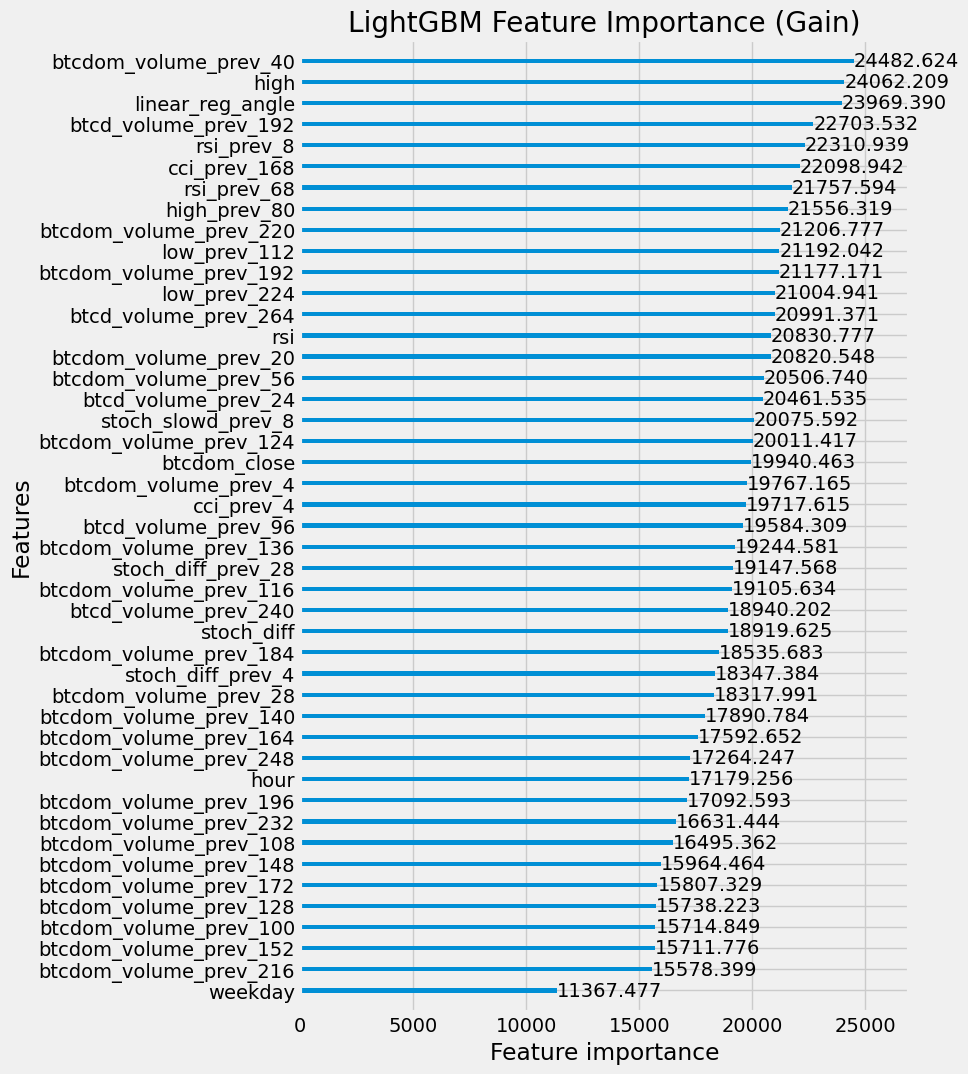

In [36]:
lgb.plot_importance(model, importance_type="gain", figsize=(7, 12), title="LightGBM Feature Importance (Gain)")
plt.show()

### Plot rolling mean ppv_npv_acc score of the model predictions for the new data

In [37]:
if not CFG.optimize and train_test == "test":
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res["target"] == 1]
    
    if len(tmp) > 0:
        tmp["ppv_npv_acc"] = tmp["target"].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

        ax = sns.lineplot(x=tmp["time"], y=tmp["ppv_npv_acc"].values)
        ax.lines[0].set_linewidth(2)
        plt.xticks(rotation=45);

<Figure size 1200x500 with 0 Axes>

# Compare indicator / signal values for bot and optimizer

In [38]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = "buy"
# ticker = "METHUSDT"
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)
# y = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, "", "", 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, "", "", 0)

# # cols = ["time", "open", "high", "low", "close", "volume", "rsi", "stoch_slowk", "stoch_slowd", "linear_reg", "linear_reg_angle", "macd", "macdsignal", "macdhist"]
# cols = ["time", "open", "high", "low", "close", "volume", "linear_reg", "linear_reg_angle", "high_max", "low_min", "volume_24"]

# higher_features = ["time_4h", "linear_reg", "linear_reg_angle", "macd", "macdhist",  "macd_dir", 
#                    "macdsignal", "macdsignal_dir"]
# y["time_4h"] = y["time"] + pd.to_timedelta(3, unit="h")
# x[["time"] + higher_features] = pd.merge(x[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# x = x.drop(columns=["time_4h"])
# y = y.drop(columns=["time_4h"])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
# v = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, "", "", 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, "", "", 0)
# z.tail(48)

# v["time_4h"] = v["time"] + pd.to_timedelta(3, unit="h")
# z[["time"] + higher_features] = pd.merge(z[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# z = z.drop(columns=["time_4h"])
# v = v.drop(columns=["time_4h"])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])